# Importing Libraries

In [1]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image as tf_image
from tqdm import tqdm

from keras.applications.vgg16 import VGG16

# Defining the train,test and model directories

* We will create the directories for train,test and model training paths if not present

In [2]:
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","vgg16")
PICKLE_PATH = os.path.join(os.getcwd(),"pickle")
TEST_CSV = os.path.join(os.getcwd(),"csv_files","test.csv")
TRAIN_CSV = os.path.join(os.getcwd(),"csv_files","train.csv")

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)

In [4]:
data_train = pd.read_csv(TRAIN_CSV)
data_test = pd.read_csv(TEST_CSV)

In [5]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

labels = to_categorical(data_train['ClassName'])
print(labels.shape)

with open(os.path.join(PICKLE_PATH,"labels_list_vgg16.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

{'c5': 0, 'c9': 1, 'c0': 2, 'c6': 3, 'c7': 4, 'c2': 5, 'c1': 6, 'c3': 7, 'c4': 8, 'c8': 9}
(22424, 10)


C:\Users\Deepak L\AppData\Local\Temp\ipykernel_2692\1325728957.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['ClassName'].replace(labels_id,inplace=True)
C:\Users\Deepak L\AppData\Local\Temp\ipykernel_2692\1325728957.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train['Cl

# Data Preparation

1. Converting the all the train and test images into image size of 64,64,3 
2. Standardizing the flattened image vector 

In [6]:
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
def path_to_tensor(img_path):
    img = tf_image.load_img(img_path, target_size=(64, 64))
    x = tf_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
    

In [7]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████| 4485/4485 [01:01<00:00, 73.03it/s] 


# MODEL ARCHITECTURE

## Approach Used
1. Removing the top layer of VGG16 model
2. Using the n-1 layers of VGG16 to predict the last layer of it using the flattened image vector 
3. The last layer thus achieved is a dense feature representation for a particular image
4. Passing this layer feature through a GlobalAveragePooling Layer and a further dense softmax layer for each of 10 classes

## Benefits

1. Making CNN architecture from scratch involves in training of all the deep layers which results in slow training
2. Instead of a large sparse image vector a dense feature representation used here requires less memory while training

In [8]:
model = VGG16(include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
train_vgg16 = model.predict(train_tensors,verbose=1)
valid_vgg16 = model.predict(valid_tensors,verbose=1)

141/141 [==============================] - 84s 594ms/step


In [10]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (17939, 2, 2, 512)
Validation shape (4485, 2, 2, 512)


In [11]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0] 

In [12]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 512)
Validation features shape (2, 2, 512)


In [13]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


In [14]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
plot_model(VGG16_model,to_file=os.path.join(os.getcwd(),"model","vgg16","model_distracted_driver_vgg16.png"),show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [17]:
model_history = VGG16_model.fit(train_vgg16,ytrain,validation_data = (valid_vgg16, ytest),epochs=400, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/400
1117/1122 [============================>.] - ETA: 0s - loss: 1.7737 - accuracy: 0.4467
Epoch 1: val_accuracy improved from -inf to 0.57458, saving model to C:\Users\Deepak L\Music\Distracted-Driver-Detection-master\model\vgg16\distracted-01-0.57.hdf5
1122/1122 [==============================] - 9s 3ms/step - loss: 1.7719 - accuracy: 0.4476 - val_loss: 1.4473 - val_accuracy: 0.5746
Epoch 2/400
1108/1122 [============================>.] - ETA: 0s - loss: 1.2553 - accuracy: 0.6573
Epoch 2: val_accuracy improved from 0.57458 to 0.68785, saving model to C:\Users\Deepak L\Music\Distracted-Driver-Detection-master\model\vgg16\distracted-02-0.69.hdf5
1122/1122 [==============================] - 3s 2ms/step - loss: 1.2534 - accuracy: 0.6579 - val_loss: 1.1386 - val_accuracy: 0.6878
Epoch 3/400
1110/1122 [============================>.] - ETA: 0s - loss: 1.0291 - accuracy: 0.7244
Epoch 3: val_accuracy improved from 0.68785 to 0.72598, saving model to C:\Users\Deepak L\Music\Distracted


Epoch 00144: val_accuracy did not improve from 0.92219
Epoch 145/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1950 - accuracy: 0.9457 - val_loss: 0.2667 - val_accuracy: 0.9202

Epoch 00145: val_accuracy did not improve from 0.92219
Epoch 146/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.2061 - accuracy: 0.9418 - val_loss: 0.2673 - val_accuracy: 0.9179

Epoch 00146: val_accuracy did not improve from 0.92219
Epoch 147/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.2007 - accuracy: 0.9440 - val_loss: 0.2690 - val_accuracy: 0.9182

Epoch 00147: val_accuracy did not improve from 0.92219
Epoch 148/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1964 - accuracy: 0.9461 - val_loss: 0.2708 - val_accuracy: 0.9202

Epoch 00148: val_accuracy did not improve from 0.92219
Epoch 149/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1981 - accuracy: 0.9463 - val_loss: 0.2697 - val_ac


Epoch 00184: val_accuracy did not improve from 0.92308
Epoch 185/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1991 - accuracy: 0.9452 - val_loss: 0.2633 - val_accuracy: 0.9233

Epoch 00185: val_accuracy improved from 0.92308 to 0.92330, saving model to /home/abhinav/distracted_driver/model/vgg16/distracted-185-0.92.hdf5
Epoch 186/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1920 - accuracy: 0.9477 - val_loss: 0.2671 - val_accuracy: 0.9202

Epoch 00186: val_accuracy did not improve from 0.92330
Epoch 187/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1927 - accuracy: 0.9473 - val_loss: 0.2662 - val_accuracy: 0.9206

Epoch 00187: val_accuracy did not improve from 0.92330
Epoch 188/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1935 - accuracy: 0.9473 - val_loss: 0.2699 - val_accuracy: 0.9186

Epoch 00188: val_accuracy did not improve from 0.92330
Epoch 189/400
1122/1122 [=================


Epoch 00224: val_accuracy did not improve from 0.92330
Epoch 225/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1916 - accuracy: 0.9476 - val_loss: 0.2699 - val_accuracy: 0.9166

Epoch 00225: val_accuracy did not improve from 0.92330
Epoch 226/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1819 - accuracy: 0.9486 - val_loss: 0.2683 - val_accuracy: 0.9208

Epoch 00226: val_accuracy did not improve from 0.92330
Epoch 227/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1869 - accuracy: 0.9487 - val_loss: 0.2738 - val_accuracy: 0.9179

Epoch 00227: val_accuracy did not improve from 0.92330
Epoch 228/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1815 - accuracy: 0.9492 - val_loss: 0.2703 - val_accuracy: 0.9217

Epoch 00228: val_accuracy did not improve from 0.92330
Epoch 229/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1882 - accuracy: 0.9499 - val_loss: 0.2773 - val_ac

1122/1122 [==============================] - 1s 1ms/step - loss: 0.1763 - accuracy: 0.9495 - val_loss: 0.2869 - val_accuracy: 0.9164

Epoch 00305: val_accuracy did not improve from 0.92330
Epoch 306/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1769 - accuracy: 0.9507 - val_loss: 0.2813 - val_accuracy: 0.9164

Epoch 00306: val_accuracy did not improve from 0.92330
Epoch 307/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1692 - accuracy: 0.9536 - val_loss: 0.2786 - val_accuracy: 0.9197

Epoch 00307: val_accuracy did not improve from 0.92330
Epoch 308/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1725 - accuracy: 0.9535 - val_loss: 0.2835 - val_accuracy: 0.9162

Epoch 00308: val_accuracy did not improve from 0.92330
Epoch 309/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1718 - accuracy: 0.9554 - val_loss: 0.2813 - val_accuracy: 0.9188

Epoch 00309: val_accuracy did not improve from 0.92330

1122/1122 [==============================] - 2s 2ms/step - loss: 0.1654 - accuracy: 0.9537 - val_loss: 0.2997 - val_accuracy: 0.9148

Epoch 00385: val_accuracy did not improve from 0.92330
Epoch 386/400
1122/1122 [==============================] - 2s 1ms/step - loss: 0.1752 - accuracy: 0.9506 - val_loss: 0.2970 - val_accuracy: 0.9153

Epoch 00386: val_accuracy did not improve from 0.92330
Epoch 387/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1792 - accuracy: 0.9506 - val_loss: 0.2969 - val_accuracy: 0.9151

Epoch 00387: val_accuracy did not improve from 0.92330
Epoch 388/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1734 - accuracy: 0.9546 - val_loss: 0.2936 - val_accuracy: 0.9204

Epoch 00388: val_accuracy did not improve from 0.92330
Epoch 389/400
1122/1122 [==============================] - 1s 1ms/step - loss: 0.1703 - accuracy: 0.9530 - val_loss: 0.2947 - val_accuracy: 0.9155

Epoch 00389: val_accuracy did not improve from 0.92330

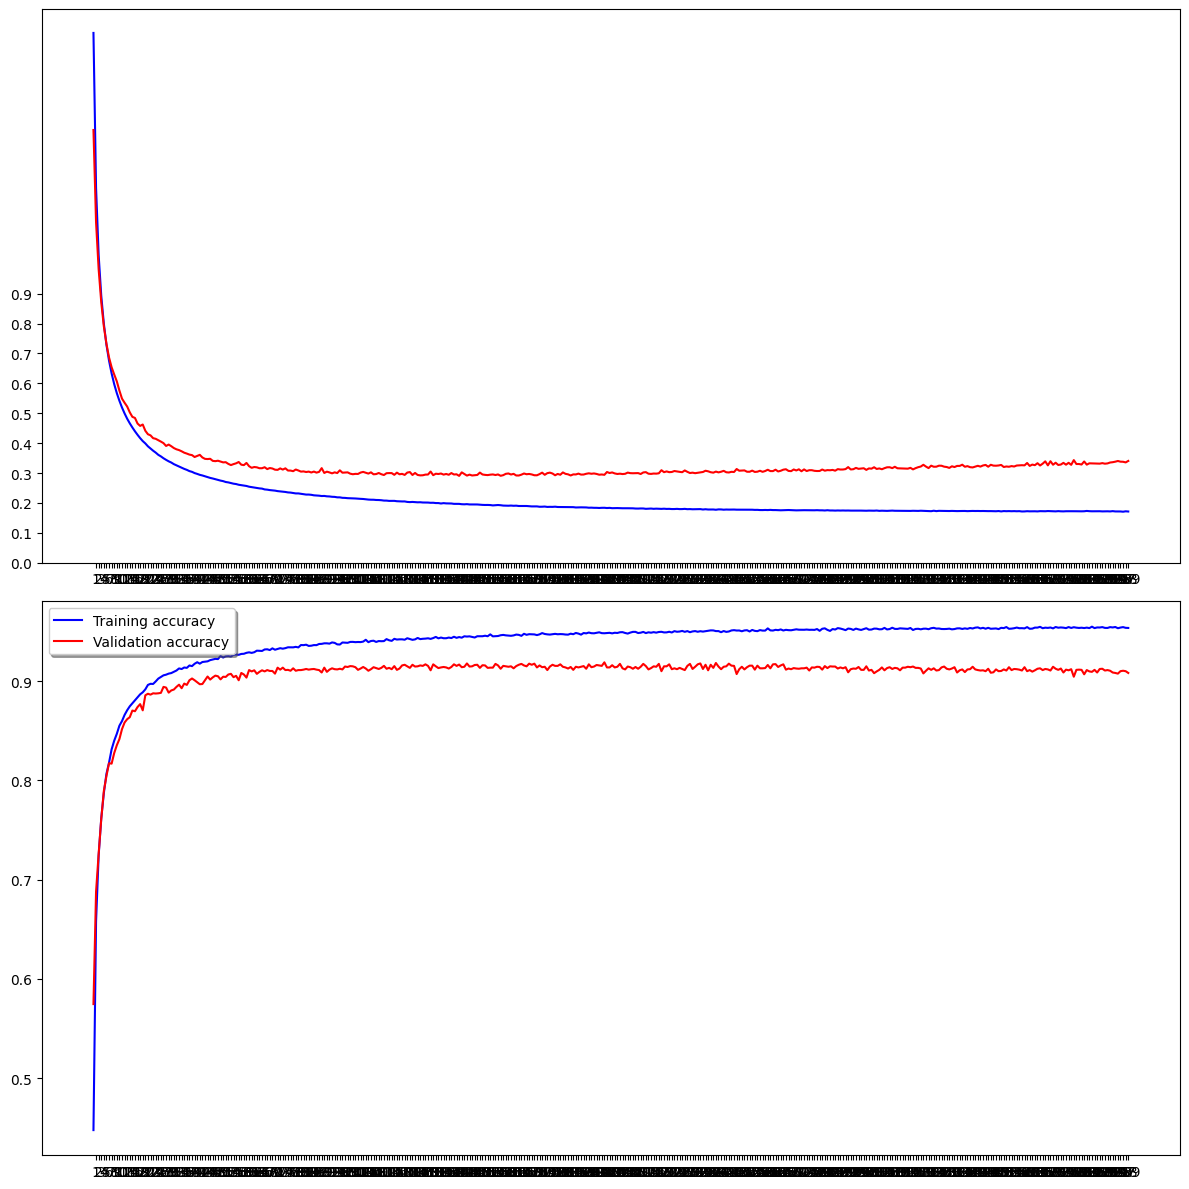

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [20]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [21]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = VGG16_model.predict(valid_vgg16,verbose=1)

141/141 [==============================] - 0s 1ms/step


## Confusion Matrix

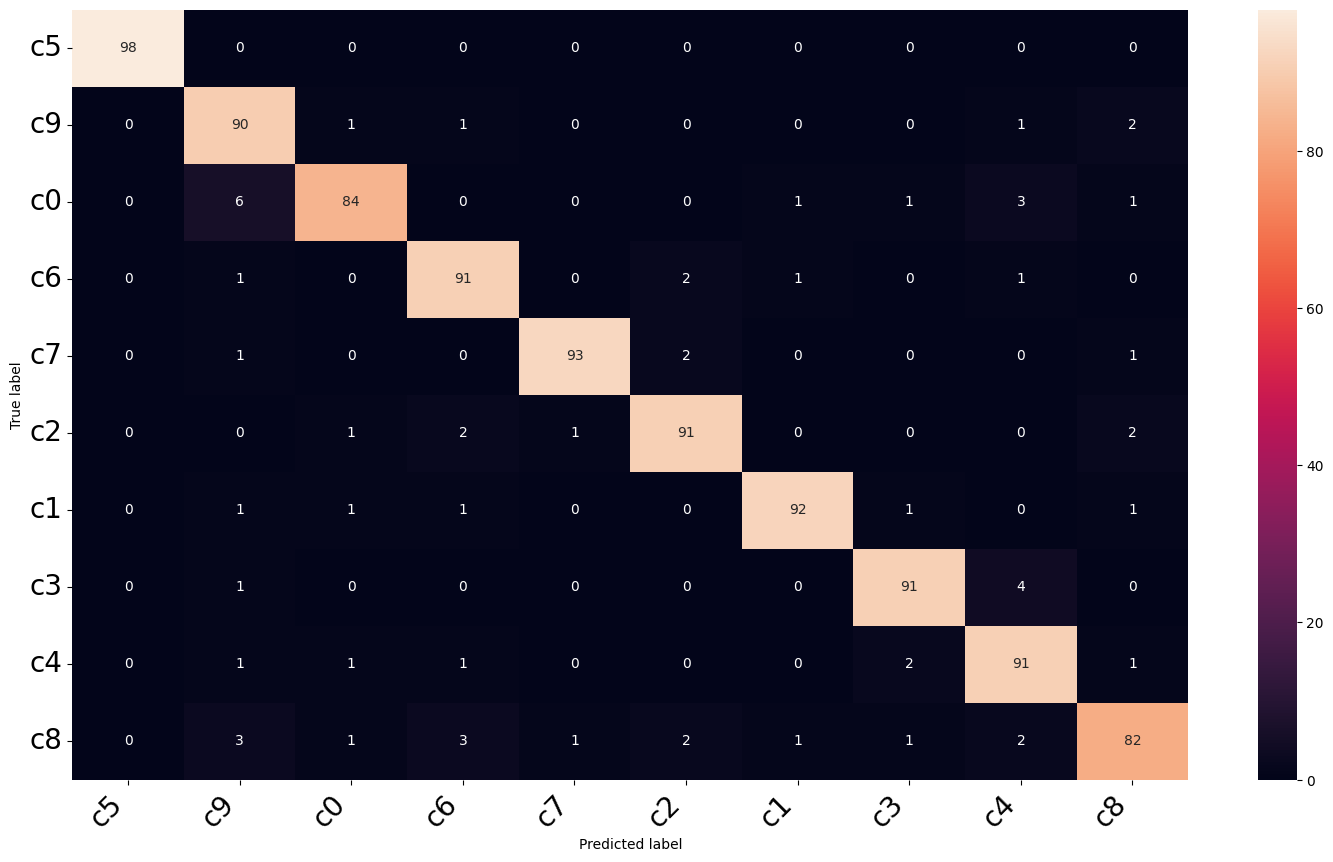

In [22]:
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [23]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [24]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.908361
Precision: 0.909556
Recall: 0.908361
F1 score: 0.908461
